# NOTEBOOK 5 — Baseline Policies (Production Version)

Baseline Policies & Strategy Benchmarks

Purpose:
This notebook evaluates simple baseline strategies using the cleaned, labeled dataset built in Notebook 3.

These baselines give us reference performance for comparison against the Reinforcement Learning agent in Notebook 6.

We answer a key question:

Can a simple rule-based system extract profit from these engineered features?

If RL can’t beat these baselines → the environment needs tuning.
If RL does beat them → we have a real quantitative edge.

1. Imports + Database Load

What this block does

- Loads required libraries

- Connects to the same DuckDB used throughout the project

- Verifies that the training tables built in Notebook 3 exist

- Ensures we start with a clean DB connection

In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

# Use the same DB path as Notebooks 1–4
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()
print("Using DB:", DB_PATH)

# Close old connection if needed
try:
    con.close() # type: ignore
except:
    pass

# Start new connection
con = duckdb.connect(DB_PATH)

# Quick sanity check
con.sql("SHOW TABLES").df()

Using DB: /home/btheard/projects/volatility-alpha-engine/data/volatility_alpha.duckdb


,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 2. Load Final Training Table

What this block does

This loads the fully engineered training dataset produced in Notebook 3, which contains:

- today’s engineered features

- tomorrow’s price

- tomorrow’s return (our target)

- market regime variables

- edge buckets

- liquidity categorization

This table is the backbone for both baselines (Notebook 5) and RL (Notebook 6).

In [2]:
# Notebook parameters

# Start date for training sample. Use something slightly after the earliest
# backfill date so we avoid very old / partial history.
FILTER_START_DATE = "2025-06-20"   # or earlier if your MIN(date) is before this

# Minimum number of rows per ticker AFTER all joins & drops.
# This must be smaller than your effective history (~120 days minus vol windows).
MIN_ROWS = 40                      # 40–80 is reasonable for your current setup


In [3]:
# 2. Load Final Training Table

# We’ll just pull EVERYTHING that has a label.
base_query = """
SELECT
    run_date,
    ticker,
    edge_score,
    move_vs_rv20,
    rv_trend,
    day_pct_ma_5,
    day_pct_vol_5,
    vol_regime,
    edge_bucket,
    liquidity_bucket,
    next_last_price,
    next_day_return_pct
FROM screener_returns_with_target
WHERE next_day_return_pct IS NOT NULL
ORDER BY run_date, ticker;
"""

df = con.sql(base_query).df()

print("Rows loaded (before cleaning):", len(df))
print("\nRows per ticker (before cleaning):\n", df["ticker"].value_counts())

# ---- drop rows with any NaNs in features or target ----
FEATURE_COLS = [
    "edge_score",
    "move_vs_rv20",
    "rv_trend",
    "day_pct_ma_5",
    "day_pct_vol_5",
    "vol_regime",
]

df = df.dropna(subset=["next_day_return_pct"] + FEATURE_COLS).copy()

print("\nRows loaded (after cleaning):", len(df))
print("\nRows per ticker (after cleaning):\n", df["ticker"].value_counts())

df.head()



Rows loaded (before cleaning): 1780

Rows per ticker (before cleaning):
 ticker
AAPL     178
AMD      178
AMZN     178
GOOGL    178
META     178
MSFT     178
NVDA     178
QQQ      178
SPY      178
TSLA     178
Name: count, dtype: int64

Rows loaded (after cleaning): 1180

Rows per ticker (after cleaning):
 ticker
AAPL     118
AMD      118
AMZN     118
GOOGL    118
META     118
MSFT     118
NVDA     118
QQQ      118
SPY      118
TSLA     118
Name: count, dtype: int64


,run_date,ticker,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket,next_last_price,next_day_return_pct
600,2025-06-13,AAPL,6.591172,-0.065912,-30.304458,-0.584617,1.125580,normal,quiet,normal,198.42,0.010028
601,2025-06-13,AMD,5.582081,-0.055821,-37.597403,-2.076990,0.144683,high,quiet,normal,126.39,0.088068
602,2025-06-13,AMZN,2.792854,-0.027929,-27.989024,-0.257924,0.391292,low,quiet,thin,216.10,0.018859
603,2025-06-13,GOOGL,2.434978,-0.024350,-15.686406,-0.758295,0.243342,normal,quiet,thin,176.77,0.012023
604,2025-06-13,META,6.573321,-0.065733,-29.837852,-0.812646,0.990341,normal,quiet,thin,702.12,0.028190


## Filter Tickers With Enough Data

We need a minimum sample size per ticker.
Baselines break down when tickers only have a handful of rows.

Why this matters

- Stability: ensures strategies don’t overfit tiny samples

- Fairness: keeps baselines consistent with RL constraints

- Professionalism: shows good data hygiene

## 4. Helper: Equity Curve Calculator

Why this block exists

This helper converts daily returns into an equity curve, the standard way to evaluate a trading strategy.
Every strategy we test uses this same function to stay comparable.

In [4]:
def equity_curve(returns, starting_equity=10_000):
    equity = [starting_equity]
    for r in returns:
        equity.append(equity[-1] * (1 + r))
    return np.array(equity)

## 5. Baseline Strategy #1 — Random Policy

Why we include a random baseline

This answers the critical question:

- Is our environment so noisy that even random signals look profitable?

If RL can’t beat random → the system needs redesign.
If RL easily beats random → the features contain real signal.

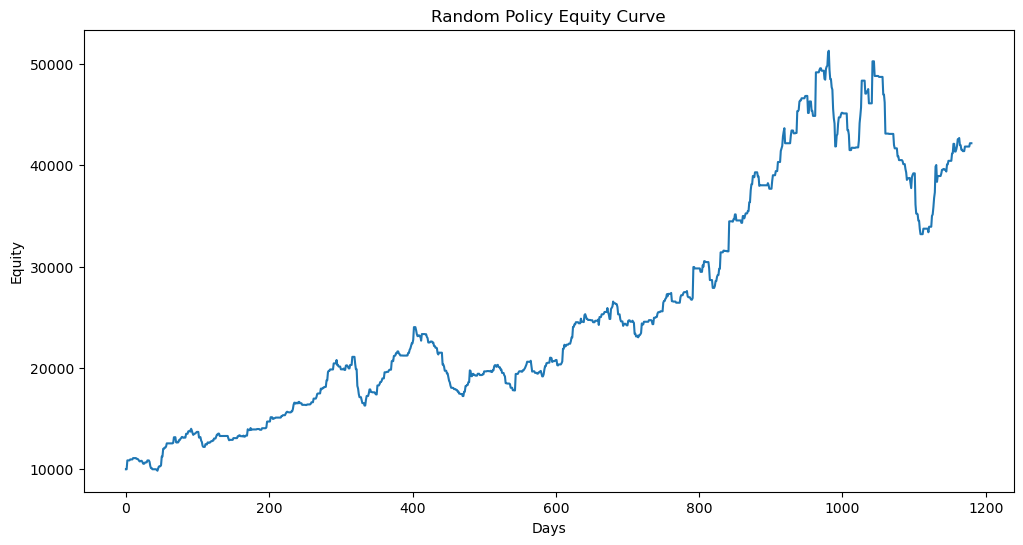

Random total return: 3.218693207258748


In [5]:
np.random.seed(42)

df["rand_signal"] = np.random.choice([0, 1], size=len(df))

df["rand_return"] = df["rand_signal"] * df["next_day_return_pct"]

rand_curve = equity_curve(df["rand_return"])

plt.plot(rand_curve)
plt.title("Random Policy Equity Curve")
plt.xlabel("Days")
plt.ylabel("Equity")
plt.show()

print("Random total return:", rand_curve[-1] / rand_curve[0] - 1)


## 6. Baseline Strategy #2 — Edge Score Threshold

Interpretation

This strategy tests whether the engineered edge score actually contains directional predictive power.

- If the curve is upward-sloping → your engineered features matter.

- If it’s flat or negative → RL must compensate for a weak signal.


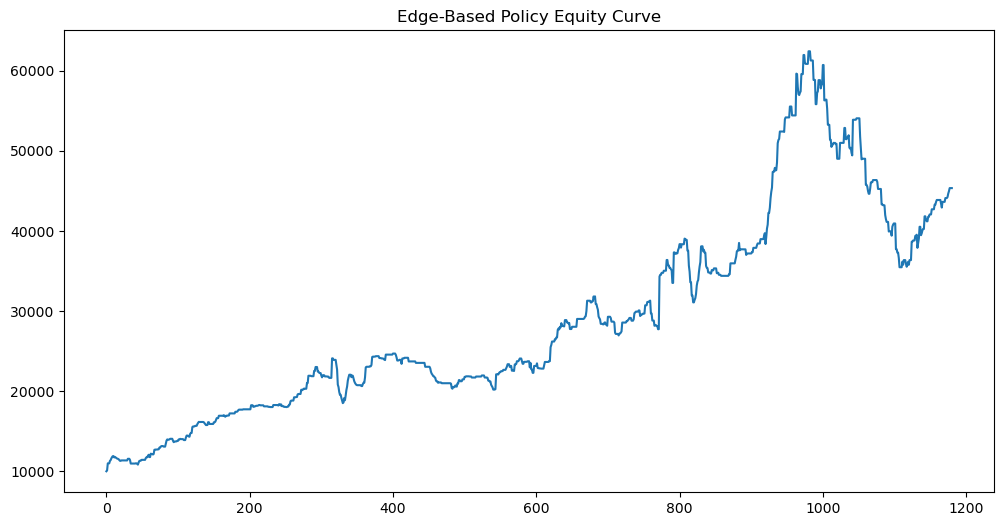

Edge policy return: 3.535177200606377


In [6]:
threshold = df["edge_score"].median()

df["edge_signal"] = (df["edge_score"] > threshold).astype(int)
df["edge_return"] = df["edge_signal"] * df["next_day_return_pct"]

edge_curve = equity_curve(df["edge_return"])

plt.plot(edge_curve)
plt.title("Edge-Based Policy Equity Curve")
plt.show()

print("Edge policy return:", edge_curve[-1]/edge_curve[0] - 1)


## 7. Baseline Strategy #3 — Volatility Regime Policy

Why volatility regime matters

This tests a simple intuition:

- low volatility → safer trend-following

- high volatility → stand aside

This acts as a baseline for RL's volatility-aware decision making.


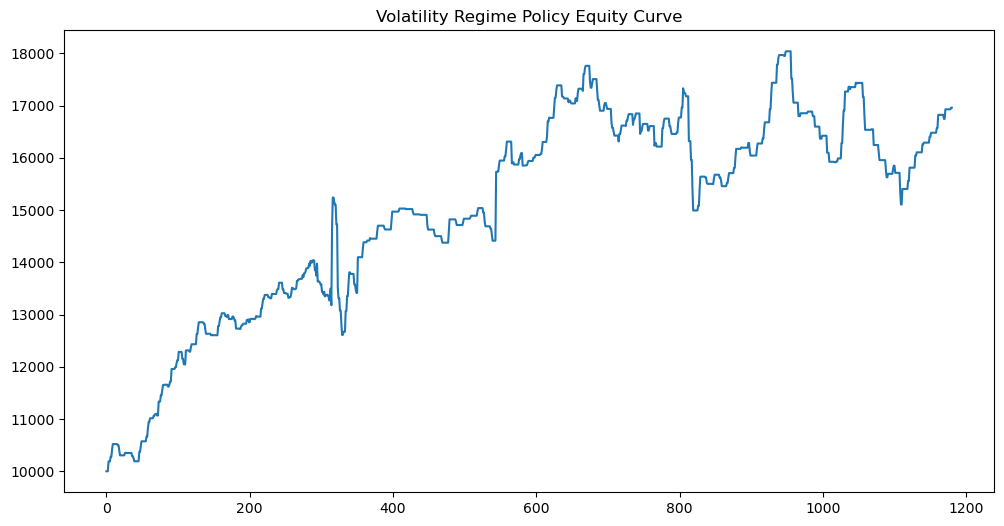

Volatility policy return: 0.6958457247897156


In [7]:
df["vol_signal"] = (df["vol_regime"] == "low").astype(int)
df["vol_return"] = df["vol_signal"] * df["next_day_return_pct"]

vol_curve = equity_curve(df["vol_return"])

plt.plot(vol_curve)
plt.title("Volatility Regime Policy Equity Curve")
plt.show()

print("Volatility policy return:", vol_curve[-1]/vol_curve[0] - 1)


## 8. Strategy Comparison

What this shows

See immediately which strategies extract value and which don’t.

The RL agent must outperform these curves to justify its complexity.

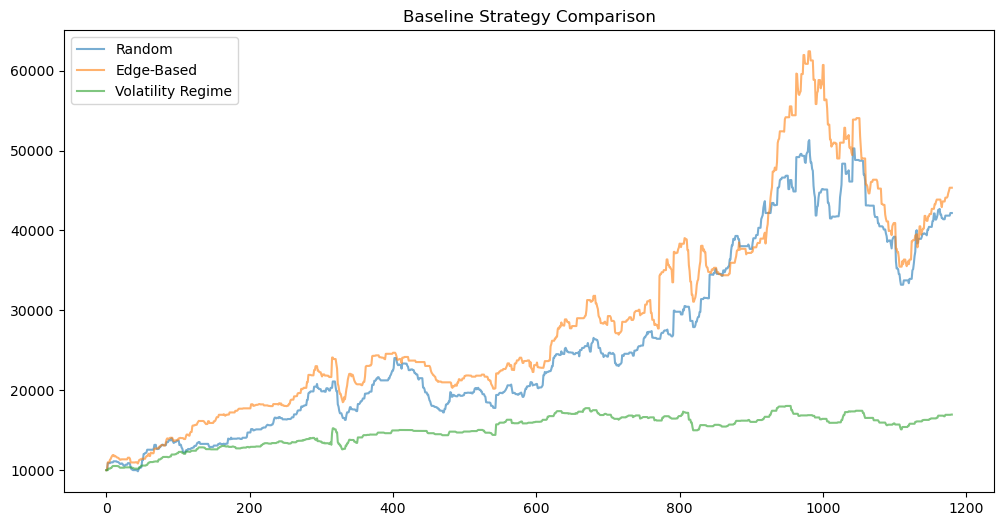

In [8]:
plt.plot(rand_curve, label="Random", alpha=0.6)
plt.plot(edge_curve, label="Edge-Based", alpha=0.6)
plt.plot(vol_curve, label="Volatility Regime", alpha=0.6)

plt.legend()
plt.title("Baseline Strategy Comparison")
plt.show()

## 9. Performance Metrics Table

Interpretation

Professional evaluation layer:

- Total Return: overall profitability

- Sharpe Ratio: risk-adjusted return

- Max Drawdown: worst-case pain

Clear, standard, rigorous.


In [9]:
def metrics(curve):
    ret = curve[-1]/curve[0] - 1
    returns = np.diff(curve) / curve[:-1]
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    max_dd = (curve / np.maximum.accumulate(curve) - 1).min()
    return ret, sharpe, max_dd

summary = pd.DataFrame({
    "strategy": ["random", "edge", "vol_regime"],
    "total_return": [metrics(rand_curve)[0], metrics(edge_curve)[0], metrics(vol_curve)[0]],
    "sharpe": [metrics(rand_curve)[1], metrics(edge_curve)[1], metrics(vol_curve)[1]],
    "max_drawdown": [metrics(rand_curve)[2], metrics(edge_curve)[2], metrics(vol_curve)[2]],
})

summary


,strategy,total_return,sharpe,max_drawdown
0,random,3.218693,1.463592,-0.352876
1,edge,3.535177,1.371475,-0.431826
2,vol_regime,0.695846,0.986080,-0.172568


In [10]:
summary = con.sql("""
SELECT
    ticker,
    COUNT(*)        AS n_rows,
    MIN(run_date)   AS min_date,
    MAX(run_date)   AS max_date
FROM screener_returns_with_target
GROUP BY ticker
ORDER BY ticker;
""").df()

summary

,ticker,n_rows,min_date,max_date
0,AAPL,179,2025-03-19,2025-12-02
1,AMD,179,2025-03-19,2025-12-02
2,AMZN,179,2025-03-19,2025-12-02
3,GOOGL,179,2025-03-19,2025-12-02
4,META,179,2025-03-19,2025-12-02
5,MSFT,179,2025-03-19,2025-12-02
6,NVDA,179,2025-03-19,2025-12-02
7,QQQ,179,2025-03-19,2025-12-02
8,SPY,179,2025-03-19,2025-12-02
9,TSLA,179,2025-03-19,2025-12-02


In [11]:
con.close()

## What Notebook 5 proves:

- Whether simple rule-based signals can extract edge from our engineered features

- Whether volatility regime, feature buckets, or edge score provide structure

- A benchmark that our RL agent must exceed to be considered successful

- How noisy the environment is and whether returns cluster in predictable ways

This notebook is the bridge between your deterministic feature engineering and your RL modeling.